In [ ]:
import wandb
wandb.init(project="VIT tuning", name="VIT_run")



wandb: Currently logged in as: khachblb06 (khachblb06-polytechnic-of-a) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Dataset


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from albumentations.pytorch import ToTensorV2



Creating transform for train and test data

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [ ]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

Downloading Dataset for train and test

In [ ]:
raw_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=None)
trainset = datasets.CIFAR10(root = 'data', train = True, download = True, transform = train_transform)
testset = datasets.CIFAR10(root = 'data', train = False, download = True, transform = test_transform)

Visualizing image before augmentation and after


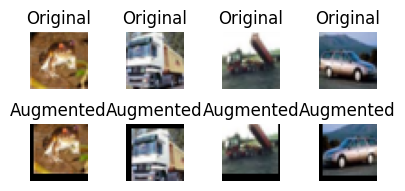

In [ ]:
def show_side_by_side(originals, augmenteds):
    fig, axes = plt.subplots(2, 4, figsize=(4, 2))
    for i in range(4):
        # Original
        orig = np.array(originals[i]) # PIL → np.array
        axes[0, i].imshow(orig)
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        # Augmented
        aug = augmenteds[i].numpy().transpose(1, 2, 0)  # CxHxW → HxWxC

        axes[1, i].imshow(aug)
        axes[1, i].axis('off')
        axes[1, i].set_title("Augmented")
    plt.tight_layout()
    plt.show()

# Get 4 same indices
indices = [0, 1, 2, 4]
originals = [raw_dataset[i][0] for i in indices]
augmenteds = [trainset[i][0] for i in indices]

# Show
show_side_by_side(originals, augmenteds)




Creating dataloaders

In [ ]:
trainloader = DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = DataLoader(testset, batch_size = 64)

I created a separate Patching class, which extracts non-overlapping 16×16 patches from the input image. This class is used to tokenize the image before passing it to the Vision Transformer model.

In [ ]:
class patching(nn.Module):
  def __init__(self, in_channels = 3, patch_size = 4, emb_size =768 ):
    super().__init__()
    self.in_channels = in_channels
    self.patch_size = patch_size
    self.emb_size = emb_size

    self.conv = nn.Conv2d(in_channels = 3, out_channels = emb_size, kernel_size = 4, stride = 4)

  def forward(self,x):
    x = self.conv(x)                # (B, 768, 8, 8)
    x = x.flatten(2)                # (B, 768, 64)
    x = x.transpose(1, 2)           # (B, 64, 768)
    return x

In [ ]:
!pip install timm


In [ ]:
import timm

I extract patch embeddings using my custom Patching class. Then, I load a pre-trained Vision Transformer model from timm. I freeze all transformer blocks except for the classification head and positional embeddings. Finally, I pass the [CLS] token to the head for classification.

In [ ]:
class AdaptedVIT(nn.Module):
  def __init__(self):
    super().__init__()
    self.patcher = patching()
    self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)

    self.vit.head = nn.Linear(self.vit.head.in_features,10)
    self.vit.patch_embed = nn.Identity()
    self.vit.pos_embed = nn.Parameter(torch.zeros(1,1+64,768))
    for name, param in self.vit.named_parameters():
        if "head" not in name and "pos_embed" not in name:
            param.requires_grad = False


  def forward(self,x):
    x = self.patcher(x)
    cls_token = self.vit.cls_token.expand(x.shape[0],-1,-1)  # (B, 1, 768)
    x = torch.cat((cls_token,x),dim = 1)  # (B, 65, 768)
    x = x + self.vit.pos_embed[:, :x.size(1), :]
    x = self.vit.blocks(x)
    x = self.vit.norm(x)
    cls_token_final = x[:, 0]
    x = self.vit.head(cls_token_final)
    return x






In [ ]:
model = AdaptedVIT()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


AdaptedVIT(
  (patcher): patching(
    (conv): Conv2d(3, 768, kernel_size=(4, 4), stride=(4, 4))
  )
  (vit): VisionTransformer(
    (patch_embed): Identity()
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(appro

In [ ]:
for epoch in range(5):
    print(f"Epoch {epoch+1}")
    print("-------------------------------")

    # Train loop
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for data, targets in trainloader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        _, predicted = outputs.max(1)
        correct_train += predicted.eq(targets).sum().item()
        total_train += data.size(0)

    train_loss /= total_train
    train_acc = correct_train / total_train

    # Test loop
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data, targets in testloader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * data.size(0)
            _, predicted = outputs.max(1)
            correct_test += predicted.eq(targets).sum().item()
            total_test += data.size(0)

    test_loss /= total_test
    test_acc = correct_test / total_test

    # logging in wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "test_loss": test_loss,
        "test_accuracy": test_acc
    })

    print(f"Train Error: \n Accuracy: {train_acc:.2f}, Avg loss: {train_loss:.6f} \n")
    print(f"Test Error: \n Accuracy: {test_acc:.2f}, Avg loss: {test_loss:.6f} \n")



Epoch 1
-------------------------------
Train Error: 
 Accuracy: 0.31, Avg loss: 1.854054 

Test Error: 
 Accuracy: 0.39, Avg loss: 1.658789 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 0.39, Avg loss: 1.654053 

Test Error: 
 Accuracy: 0.42, Avg loss: 1.586296 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 0.43, Avg loss: 1.559047 

Test Error: 
 Accuracy: 0.47, Avg loss: 1.455728 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 0.45, Avg loss: 1.505390 

Test Error: 
 Accuracy: 0.48, Avg loss: 1.448930 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 0.47, Avg loss: 1.454775 

Test Error: 
 Accuracy: 0.51, Avg loss: 1.376547 



In [ ]:
wandb.finish()


epoch,▁▃▅▆█
test_accuracy,▁▃▆▆█
test_loss,█▆▃▃▁
train_accuracy,▁▄▆▇█
train_loss,█▄▃▂▁
epoch,5
test_accuracy,0.5107
test_loss,1.37655
train_accuracy,0.4732
train_loss,1.45477
